In [1]:
import pickle
from os.path import join
import pandas as pd
import numpy as np

from sklearn import svm
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels

from utils import heatmap, annotate_heatmap
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

Accumulate training data from regions in one dataframe

In [2]:
regions = ['borde_rural'] # add the other regions!

In [3]:
columns = ['id', 'features', 'label']
df_train_global = pd.DataFrame(columns=columns)

pickle_path = join('..', '..', 'pickles')
for region in regions:
    #try:
        with open(join(pickle_path, 'resnet50_features_' + region + '_train.pkl'), 'rb') as f:
            df_train = pickle.load(f)
            df_train_global = pd.concat([df_train_global, df_train])
    #except:
    #    print("Error reading training data for region ", region)
    

Convert the dataframe to a matrix

In [4]:
feature_matrix = df_train_global['features'].to_numpy()
feature_matrix = np.column_stack(feature_matrix).transpose()
print(feature_matrix.shape)

labels = df_train_global['label'].to_numpy().astype('int')

(4353, 2048)


Split into training and test set

In [5]:
features_train, features_test, labels_train, labels_test = train_test_split(feature_matrix,
                                                                            labels,
                                                                            test_size=0.33,
                                                                            random_state=80)

## Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
n_est_candidates = [10, 200]
max_depth_candidates = [8, 16, 24]
losses = np.empty((len(n_est_candidates), len(max_depth_candidates)))

In [15]:
for idx_n, n_est in enumerate(n_est_candidates):
    print("Training with n_est=", n_est)
    for idx_m, max_depth in enumerate(max_depth_candidates):
        print("Training with max_depth=", max_depth)

        clf_rf = RandomForestClassifier(n_estimators=n_est,
                                        max_depth=max_depth,
                                        max_features = None,
                                        verbose=True)
        clf_rf.fit(features_train, labels_train) 
        
        pred_prob = clf_rf.predict_proba(features_test)
        losses[idx_n, idx_m] = log_loss(labels_test, pred_prob, eps=1e-15)

Training with n_est= 10
Training with max_depth= 8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   42.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training with max_depth= 16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training with max_depth= 24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Training with n_est= 200
Training with max_depth= 8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 14.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


Training with max_depth= 16


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 21.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


Training with max_depth= 24


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

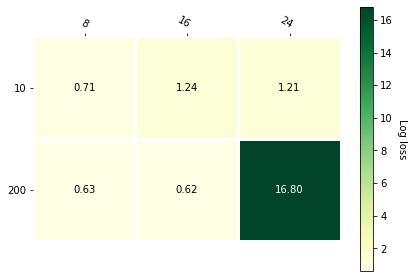

In [16]:
fig, ax = plt.subplots()
im, cbar = heatmap(losses, n_est_candidates, max_depth_candidates, ax=ax,
                   cmap="YlGn", cbarlabel="Log loss")
texts = annotate_heatmap(im)

fig.tight_layout()
plt.show()

## SVM: Grid-search good parameters for C and gamma

Train a classifier, predict the probabilities and compute the log-loss.

In [ ]:
import numpy as np

C_candidates = [0.5, 1, 5, 10, 50, 100, 500, 1000, 5000]
gamma_candidates = [1e-8, 5e-8, 1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4]
losses = np.empty((len(C_candidates), len(gamma_candidates)))

In [ ]:
for idx_g, gamma in enumerate(gamma_candidates):
    print("Training with gamma=", gamma)
    for idx_c, C in enumerate(C_candidates):
        print("Training with C=", C)
        clf = svm.SVC(kernel='rbf',
                      gamma=gamma,
                      probability=True,
                      C=C,
                      decision_function_shape='ovr',
                      class_weight='balanced')
        clf.fit(features_train, labels_train)
        pred_prob = clf.predict_proba(features_test)
        losses[idx_c, idx_g] = log_loss(labels_test, pred_prob, eps=1e-15)

In [ ]:
fig, ax = plt.subplots()
im, cbar = heatmap(losses, C_candidates, gamma_candidates, ax=ax,
                   cmap="YlGn", cbarlabel="Log loss")
texts = annotate_heatmap(im)

fig.tight_layout()
plt.show()

Plot the loss over the different values for C

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.semilogx(C_candidates, losses)